# Plot CoMIGHT results for S@98 versus n_samples and n_dims_1

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sktree.datasets import make_trunk_classification
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
root_dir = Path("/Volumes/Extreme Pro/cancer")
SIMULATIONS_NAMES = [
    "mean_shift_compounding",
    # "mean_shift",
    # "multi_modal",
    "multi_modal_compounding",
    "multi_equal",
]
model_name = "comight"

model_names = [
    "comight",
    "might_viewone",
    "might_viewtwo",
    "might_viewoneandtwo",
    "knn",
]

n_dims_2_ = 6

# Sensitivity at 98% Specificity (S@98)

## Varying the number of samples

In [5]:
n_samples_list = [2**x for x in range(8, 13)]
n_dims_1 = 4090
n_repeats = 100
print(n_samples_list)

[256, 512, 1024, 2048, 4096]


In [6]:
results = defaultdict(list)

for sim_name in SIMULATIONS_NAMES:
    for model_name in model_names:
        for n_samples in n_samples_list:
            for idx in range(n_repeats):
                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims_1}_{n_dims_2_}_{idx}.npz"
                )
                # print(output_fname)
                # print(output_fname.exists())

                # print(output_fname.exists())
                # Load data from the compressed npz file
                try:
                    loaded_data = np.load(output_fname)
                except Exception as e:
                    print(e, output_fname)
                    continue

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims_1 = loaded_data["n_dims_1"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]
                # threshold = loaded_data["threshold"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims_1"].append(n_dims_1)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)
                # results["threshold"].append(threshold)

File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_0.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_1.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_2.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_3.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_4.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_5.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_6.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/knn/mean_shift_compounding/mean_shift_compounding_256_4090_6_8.npz


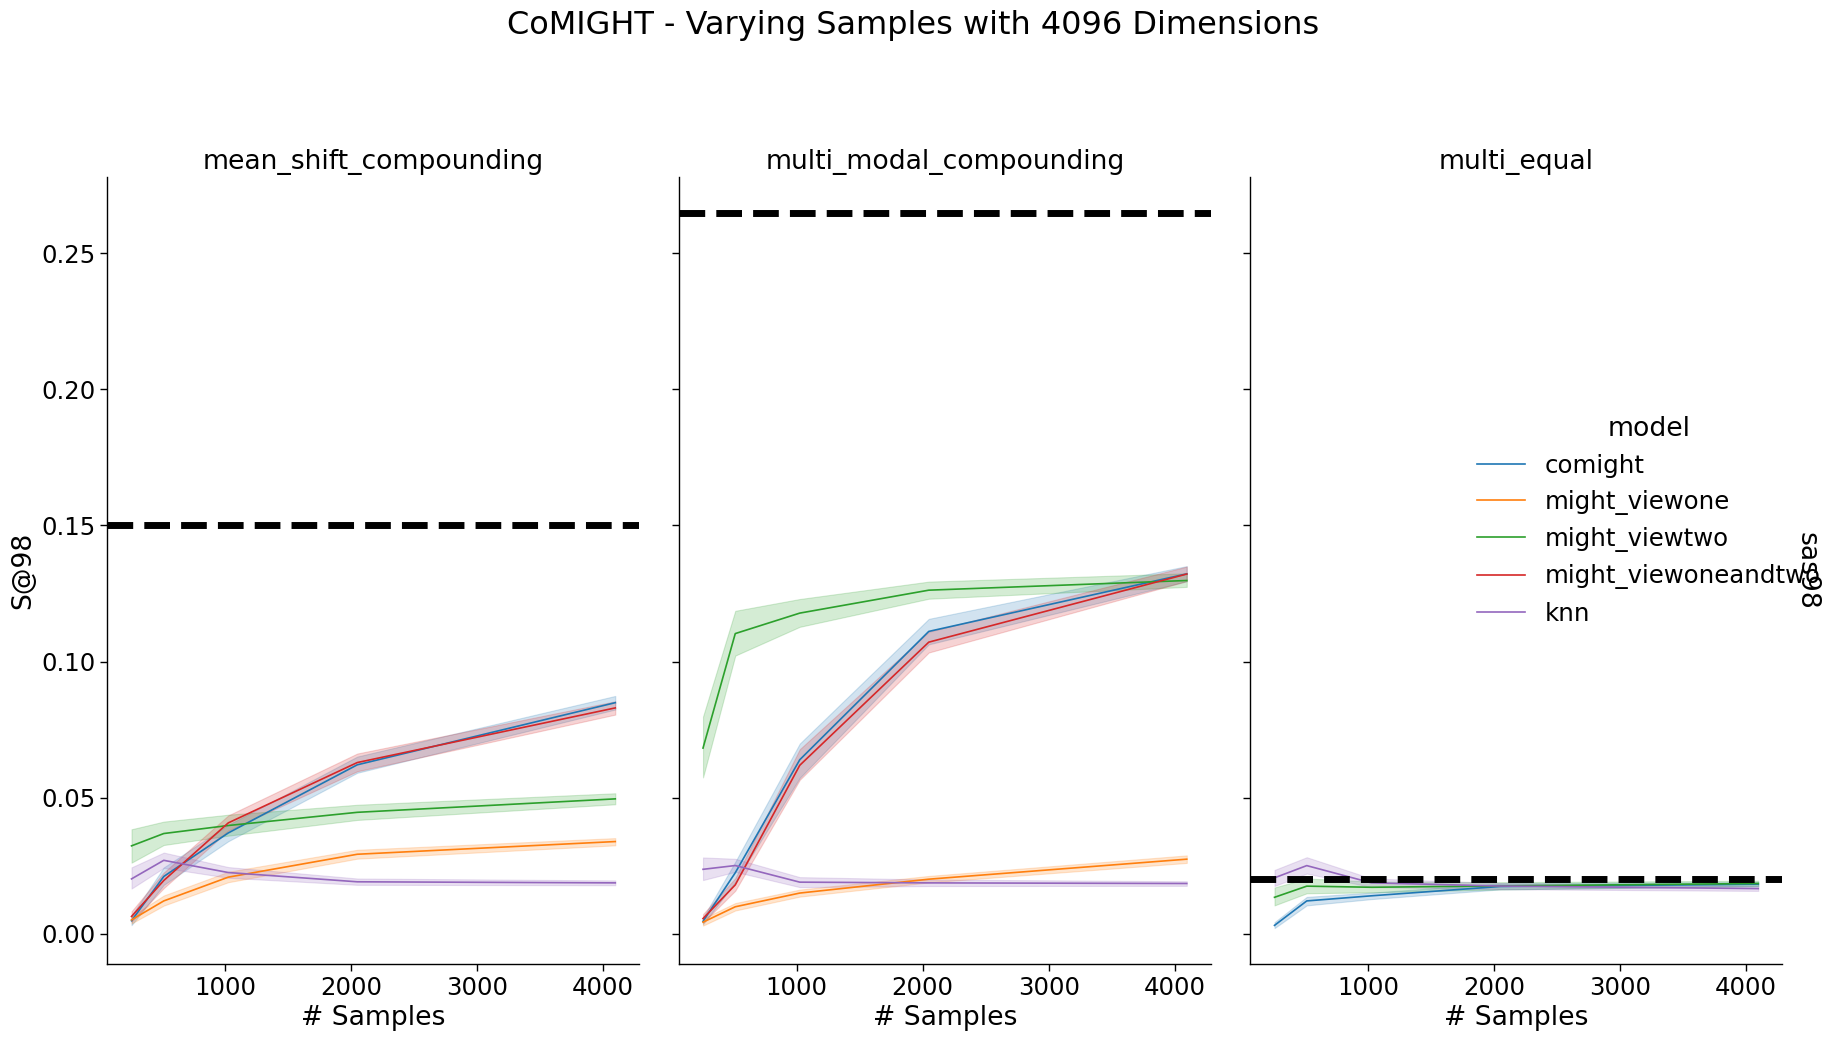

In [7]:
df = pd.DataFrame(results)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
# df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=10.0,
    aspect=0.5,
)
g.map(sns.lineplot, "n_samples", "metric_value")

# iterate through the axes

g.axes[0][0].axhline([0.15], ls="--", linewidth=5, c="black", label="Truth")
g.axes[0][1].axhline([0.265], ls="--", linewidth=5, c="black", label="Truth")
g.axes[0][2].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][3].axhline([0.22], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][4].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

# g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "S@98")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("CoMIGHT - Varying Samples with 4096 Dimensions", y=1.05)
g.fig.tight_layout()
plt.show()

## Varying Dims

In [8]:
n_dims_list = [2**x - 6 for x in range(3, 13)]
n_samples = 4096
n_repeats = 100
print(n_dims_list)

[2, 10, 26, 58, 122, 250, 506, 1018, 2042, 4090]


In [9]:
results = defaultdict(list)

for sim_name in SIMULATIONS_NAMES:
    for model_name in ["comight"]:
        for n_dims_1 in n_dims_list:
            for idx in range(n_repeats):
                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims_1}_{n_dims_2_}_{idx}.npz"
                )
                # print(output_fname)
                # print(output_fname.exists())

                # print(output_fname.exists())
                # Load data from the compressed npz file
                try:
                    loaded_data = np.load(output_fname)
                except Exception as e:
                    print(e, output_fname)
                    continue

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims_1 = loaded_data["n_dims_1"]
                sas98 = loaded_data["sas98"]
                sim_name = loaded_data["sim_type"]
                threshold = loaded_data["threshold"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims_1"].append(n_dims_1)
                results["sas98"].append(sas98)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)
                results["threshold"].append(threshold)

[Errno 2] No such file or directory: '/Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_34.npz' /Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_34.npz
[Errno 2] No such file or directory: '/Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_35.npz' /Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_35.npz
[Errno 2] No such file or directory: '/Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_36.npz' /Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_36.npz
[Errno 2] No such file or directory: '/Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding_4096_2042_6_37.npz' /Volumes/Extreme Pro/cancer/output/comight/mean_shift_compounding/mean_shift_compounding

IndexError: index 3 is out of bounds for axis 0 with size 3

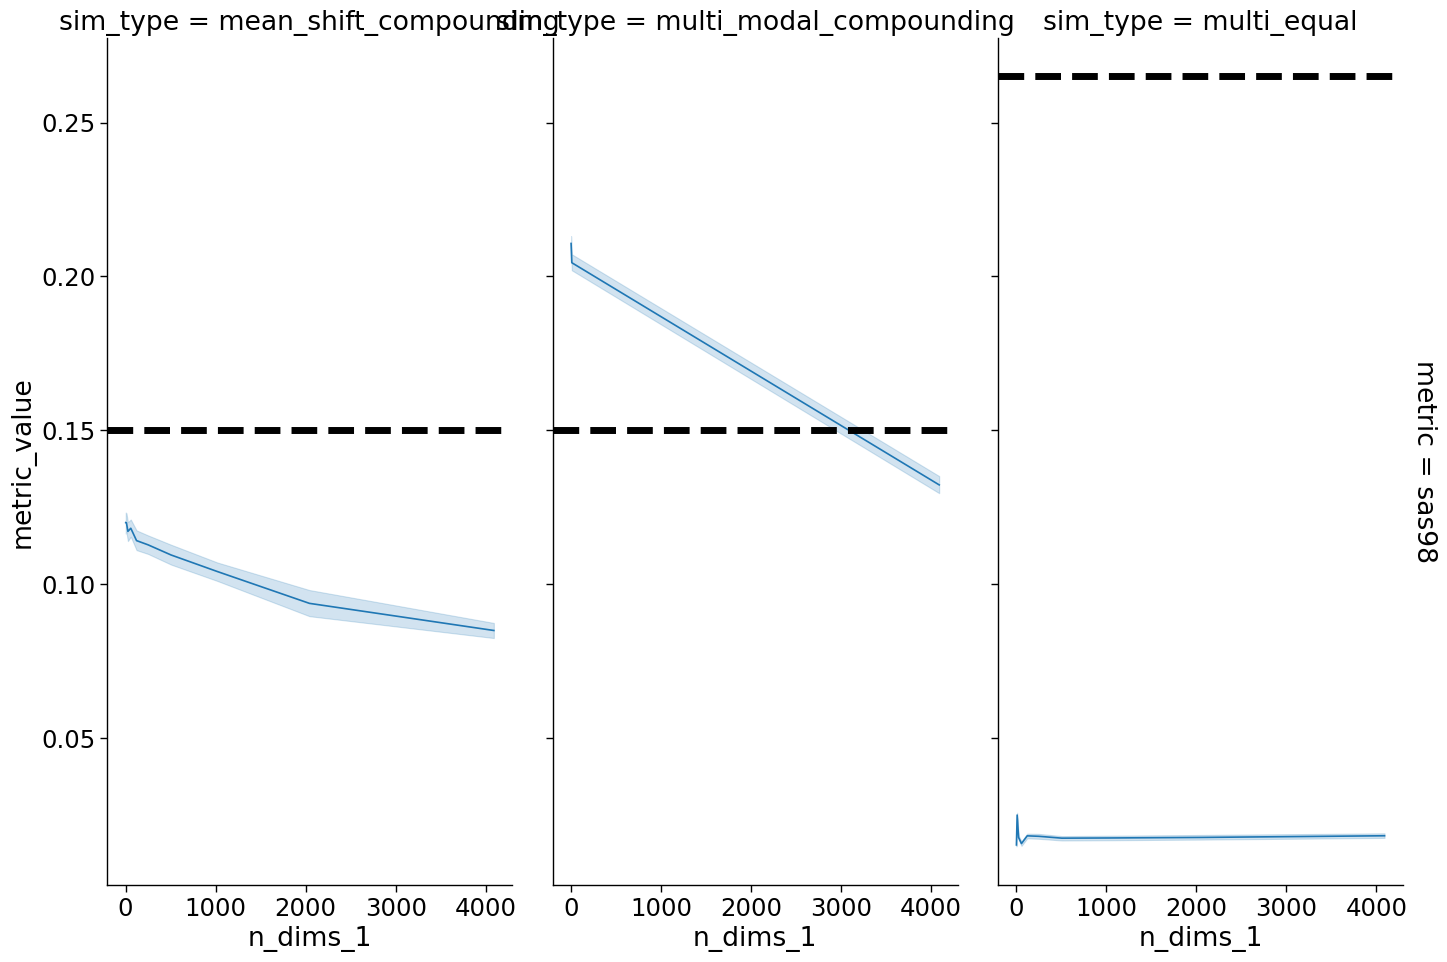

In [10]:
df = pd.DataFrame(results)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_dims_1", "sim_type", "model"],
    value_vars=["sas98"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
# df_melted["n_dims"] = df_melted["n_dims"].astype(int)
df_melted["n_dims_1"] = df_melted["n_dims_1"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)
# df_melted["sim_type"] = pd.Categorical(df_melted["sim_type"], categories=df["sim_type"].unique(), ordered=True)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=10.0,
    aspect=0.5,
)
g.map(sns.lineplot, "n_dims_1", "metric_value")

# iterate through the axes

g.axes[0][0].axhline([0.15], ls="--", linewidth=5, c="black", label="Truth")
g.axes[0][1].axhline([0.15], ls="--", linewidth=5, c="black", label="Truth")
g.axes[0][2].axhline([0.265], ls="--", linewidth=5, c="black", label="Truth")
g.axes[0][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][4].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

# g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "S@98")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("CoMIGHT - Varying Samples with 4096 Dimensions", y=1.05)
g.fig.tight_layout()
plt.show()

# Conditional Mutual Information (CMI)

## Varying number of samples

In [19]:
n_samples_list = [2**x for x in range(8, 13)]
n_dims_1 = 4090
n_repeats = 100
print(n_samples_list)

[256, 512, 1024, 2048, 4096]


In [20]:
SIMULATIONS_NAMES = [
    "mean_shift_compounding",
    "multi_modal_compounding",
    "multi_equal",
]

In [21]:
print(dict(loaded_data).keys())

dict_keys(['idx', 'n_samples', 'n_dims_1', 'n_dims_2', 'cmi', 'I_X1X2_Y', 'I_X1_Y', 'sim_type', 'y', 'posterior_arr', 'perm_posterior_arr'])


In [26]:
results = defaultdict(list)

for sim_name in SIMULATIONS_NAMES:
    for model_name in [
        "comight-cmi",
        # "ksg"
    ]:
        for n_samples in n_samples_list:
            for idx in range(n_repeats):
                output_fname = (
                    root_dir
                    / "output"
                    / model_name
                    / sim_name
                    / f"{sim_name}_{n_samples}_{n_dims_1}_{n_dims_2_}_{idx}.npz"
                )
                # print(output_fname)
                # print(output_fname.exists())

                # print(output_fname.exists())
                # Load data from the compressed npz file
                try:
                    loaded_data = np.load(output_fname)
                except Exception as e:
                    print(e, output_fname)
                    continue

                # Extract variables with the same names
                idx = loaded_data["idx"]
                n_samples = loaded_data["n_samples"]
                n_dims_1 = loaded_data["n_dims_1"]
                cmi = loaded_data["cmi"]
                sim_name = loaded_data["sim_type"]

                results["idx"].append(idx)
                results["n_samples"].append(n_samples)
                results["n_dims_1"].append(n_dims_1)
                results["cmi"].append(cmi)
                results["sim_type"].append(sim_name)
                results["model"].append(model_name)

File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_18.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_19.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_20.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_21.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_22.npz
File is not a zip file /Volumes/Extreme Pro/cancer/output/comight-cmi/mean_shift_compounding/mean_shift_compounding_4096_4090_6_24.npz
[Errno 2] No such file or directory: '/Volumes/Extreme Pro/cancer/output/comight-cmi/multi_modal_compounding/multi_modal_compounding_4096_4090_6_16.npz' /Volumes/Extreme Pro/cancer/output/co

In [23]:
print(df.shape)
display(df[df["model"] == "comight"].head())

(1199, 6)


,idx,n_samples,n_dims_1,cmi,sim_type,model


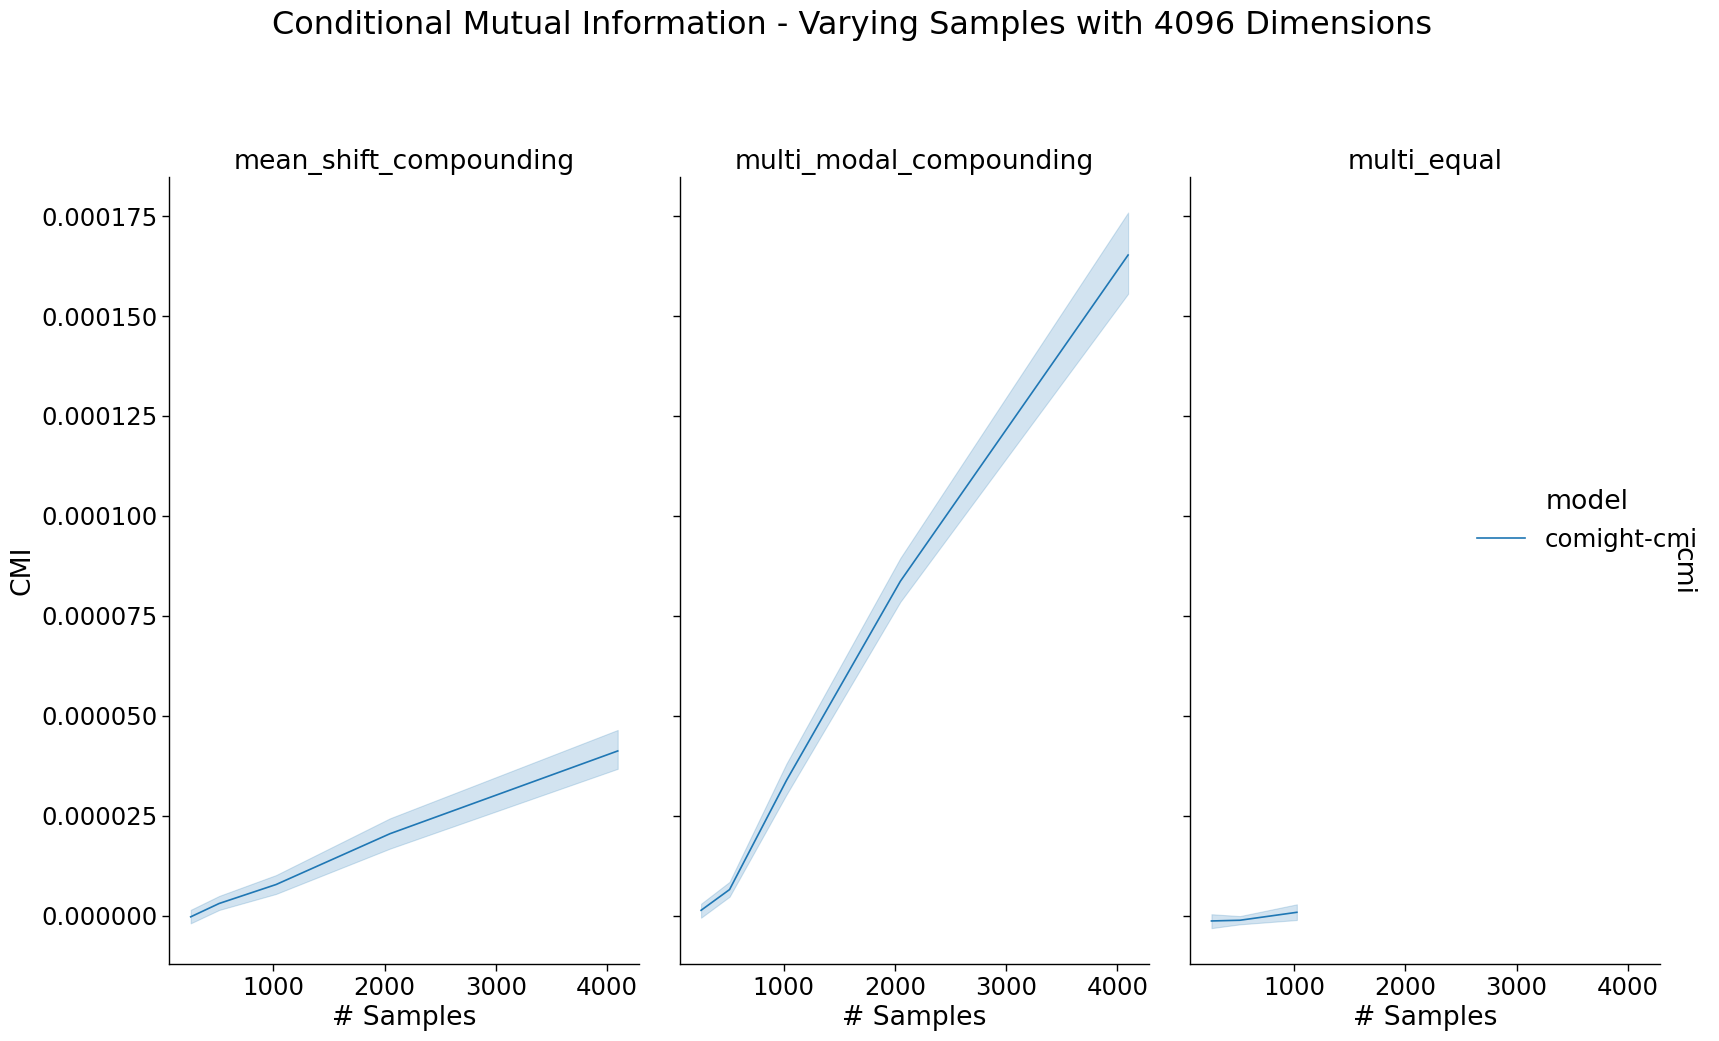

In [24]:
df = pd.DataFrame(results)

# Melt the DataFrame to reshape it
df_melted = pd.melt(
    df,
    id_vars=["n_samples", "sim_type", "model"],
    value_vars=["cmi"],
    var_name="metric",
    value_name="metric_value",
)

# Convert "sim_type" to categorical type
df_melted["sim_type"] = df_melted["sim_type"].astype(str)
df_melted["model"] = df_melted["model"].astype(str)
df_melted["n_samples"] = df_melted["n_samples"].astype(int)
df_melted["metric_value"] = df_melted["metric_value"].astype(float)

# Now, let's create the plot using Seaborn
# sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0)

g = sns.FacetGrid(
    df_melted,
    col="sim_type",
    row="metric",
    hue="model",
    margin_titles=True,
    height=10.0,
    aspect=0.5,
)
g.map(sns.lineplot, "n_samples", "metric_value")

# iterate through the axes

# g.axes[0][0].axhline([0.15], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][1].axhline([0.15], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][2].axhline([0.265], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][3].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")
# g.axes[0][4].axhline([0.02], ls="--", linewidth=5, c="black", label="Truth")

# g.axes[0][1].set(yscale="log", ylim=[0.3, 1])
# g.axes[1][].set(yscale="log")

# Adjust the plot layout
g.set_axis_labels("# Samples", "CMI")
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle(
    "Conditional Mutual Information - Varying Samples with 4096 Dimensions", y=1.05
)
g.fig.tight_layout()
plt.show()

## Varying number of dims

In [48]:
n_dims_1_list = [2**i - 6 for i in range(3, 12)[::2]] + [2**12 - 6]
print(n_dims_1_list)

[2, 26, 122, 506, 2042, 4090]
